# Analysis of the modifier effect of N264K variant in UKB

In [ ]:
#First we import the necessary tools:
import pandas as pd
import dxpy
import dxdata
import numpy as np
import re
import shutil
import subprocess
import glob
import os
import ast

In [2]:
#Get the relevant variant information in the exome data:
from bgen import BgenReader
fn = "/mnt/project/Bulk/Exome sequences/Population level exome OQFE variants, BGEN format - final release/ukb23159_c22_b0_v1.sample"
sns = pd.read_csv(fn, sep=" ")
sns = sns.iloc[1:,:]
sns = sns.ID_1
fn = "/mnt/project/Bulk/Exome sequences/Population level exome OQFE variants, BGEN format - final release/ukb23159_c22_b0_v1.bgen"
bfile = BgenReader(fn)

v = bfile.with_rsid("22:36265284:G:A")
v1 = pd.Series(v[0].alt_dosage)
v1.index = sns

g2v = bfile.with_rsid("22:36265995:AATAATT:A")
g2 = pd.Series(g2v[0].alt_dosage)
g2.index = sns

g1mv = bfile.with_rsid("22:36265988:T:G")
g1m = pd.Series(g1mv[0].alt_dosage)
g1m.index = sns

#VX (we call the modifier variant VX here)
vxv = bfile.with_rsid("22:36265628:C:A")
vx = pd.Series(vxv[0].alt_dosage)
vx.index = sns

/tmp/ipykernel_82/572631366.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  sns = pd.read_csv(fn, sep=" ")


In [3]:
#ancestry:
ans = pd.read_csv("/mnt/project/Datasets/Ancestry/panukbb_ancestry.txt", sep="\t", index_col=0)
ans.set_index("individual_id", inplace=True)
ans.index = ans.index.astype(int)
ans = ans[~ans.index.duplicated(keep="first")]

In [4]:
#Covariates (just in case):
DATASET_ID = "project-GpFPQ70JK9p66XgZZjYxPPy4:record-GpQgFFQJqGYgJ11z9b0v23FK"
dataset = dxdata.load_dataset(id=DATASET_ID)
participant = dataset['participant']
field_age = participant.find_field(title="Age at recruitment")
field_sex = participant.find_field(title="Sex")
field_eid = participant.find_field(name="eid")
agesex = participant.retrieve_fields(engine=dxdata.connect(), fields=[field_eid, field_age, field_sex], coding_values="replace").toPandas()
agesex.set_index("eid", inplace=True)
agesex.columns = ["age", "sex"]
agesex["sex"] = agesex.sex.str.replace("Female","0").str.replace("Male","1").astype(int)


In [5]:
#APOL1:
olinkdata = dataset['olink_instance_0']
field_apol1 = olinkdata.find_field(name="apol1")
apol1 = olinkdata.retrieve_fields(engine=dxdata.connect(), fields=[field_eid]+[field_apol1], coding_values="replace")
apol1 = apol1.toPandas().set_index("eid").squeeze()
apol1 = apol1[~apol1.isna()]

In [6]:
#Combine
df = pd.concat([v1, g1m, g2, vx], axis=1)
df.columns = ["v1", "g1", "g2", "vx"]
df.index = df.index.astype(str)
ans.index = ans.index.astype(str)
df = df.join(apol1, how="inner")
df = df.join(ans["pop"], how="left")
df = df.join(agesex, how="inner")

In [7]:
#Filter to AFR:
dfa = df[df["pop"]=="AFR"]

/tmp/ipykernel_82/2061121549.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfa["rd"] = np.random.rand(dfa.shape[0])/3 - 1/6


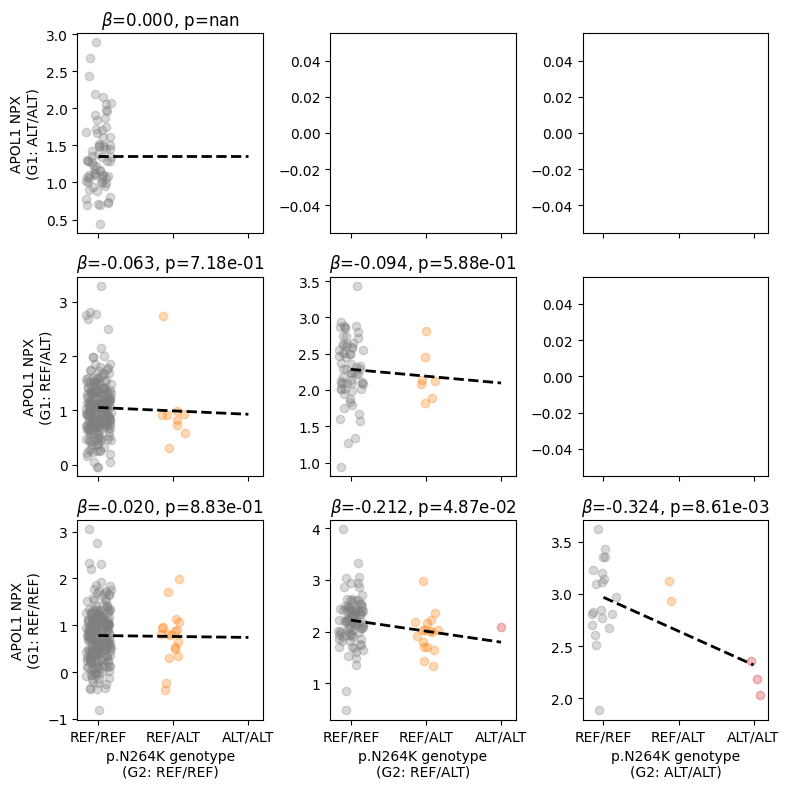

In [8]:
#3x3 plots
import random as rd
from matplotlib import pyplot as plt
import statsmodels.api as sm
def linear_regression(x, y):
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    intcpt = model.params[0]
    beta = model.params[1]
    p_value = model.pvalues[1]
    return [beta, intcpt, p_value]

np.random.seed(2)
dfa["rd"] = np.random.rand(dfa.shape[0])/3 - 1/6
colors = ["tab:grey", "tab:orange", "tab:red"]
labels = ["REF/REF", "REF/ALT", "ALT/ALT"]
fig, ax = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=False)
for i in range(3):
    for j in range(3):
        try:
            st = dfa[(dfa.g1==i)&(dfa.g2==j)]
            for k in range(3):
                stsub = st[st.vx==k]
                ax[2-i][j].scatter(k+stsub.rd, stsub.apol1, color=colors[k], alpha=0.3)
            slope, intercept, pval = linear_regression(st.vx, st.apol1)
            ax[2-i][j].plot(np.array([0,2]),np.array([0,2])*slope+intercept, linestyle="--", linewidth=2, color="black")
            ax[2-i][j].set_title(f"$\\beta$={slope:.3f}, p={pval:.2e}", fontsize=12)
        except:
            pass #For non-existing genotypes
for j in range(3):
    ax[2][j].set_xlabel("p.N264K genotype\n(G2: "+labels[j]+")")
    ax[2-j][0].set_ylabel("APOL1 NPX\n(G1: "+labels[j]+")")
    ax[2][j].set_xticks([0,1,2])
    ax[2][j].set_xticklabels(labels)
plt.tight_layout()
plt.savefig("n264k_effects.png", dpi=400)
plt.savefig("n264k_effects.pdf", dpi=400)
plt.show()
plt.close()